# Finding the size of the chemical space

Load data.

In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Count reaction compatibilities.

In [101]:
from tqdm.auto import tqdm
from collections import defaultdict

counts = defaultdict(list)
for building_block in tqdm(building_blocks):
    if building_block:
        for reaction in reactions:
            for idx, reactant in enumerate(reaction.reactants):
                if building_block.HasSubstructMatch(reactant):
                    try:
                        counts[reaction.name][idx] += 1
                    except:
                        counts[reaction.name].append(1)
                        
counts = dict(counts)

  0%|          | 0/262336 [00:00<?, ?it/s]

In [144]:
import math

total_products = []
for reaction, counts_ in counts.items():
    total_products.append({
        'Reaction': reaction,
        'Total Products': math.prod(counts_)
    })

total_products = pd.DataFrame(total_products)
total_products['Reaction'] = total_products['Reaction'].str.split('_', n=1).str[1]

oom = lambda n: int(math.log10(n))
total_products['Order of Magnitude'] = -total_products['Total Products'].apply(oom)

Text(0.5, 1.0, 'Size of chemical space with Enamine building blocks')

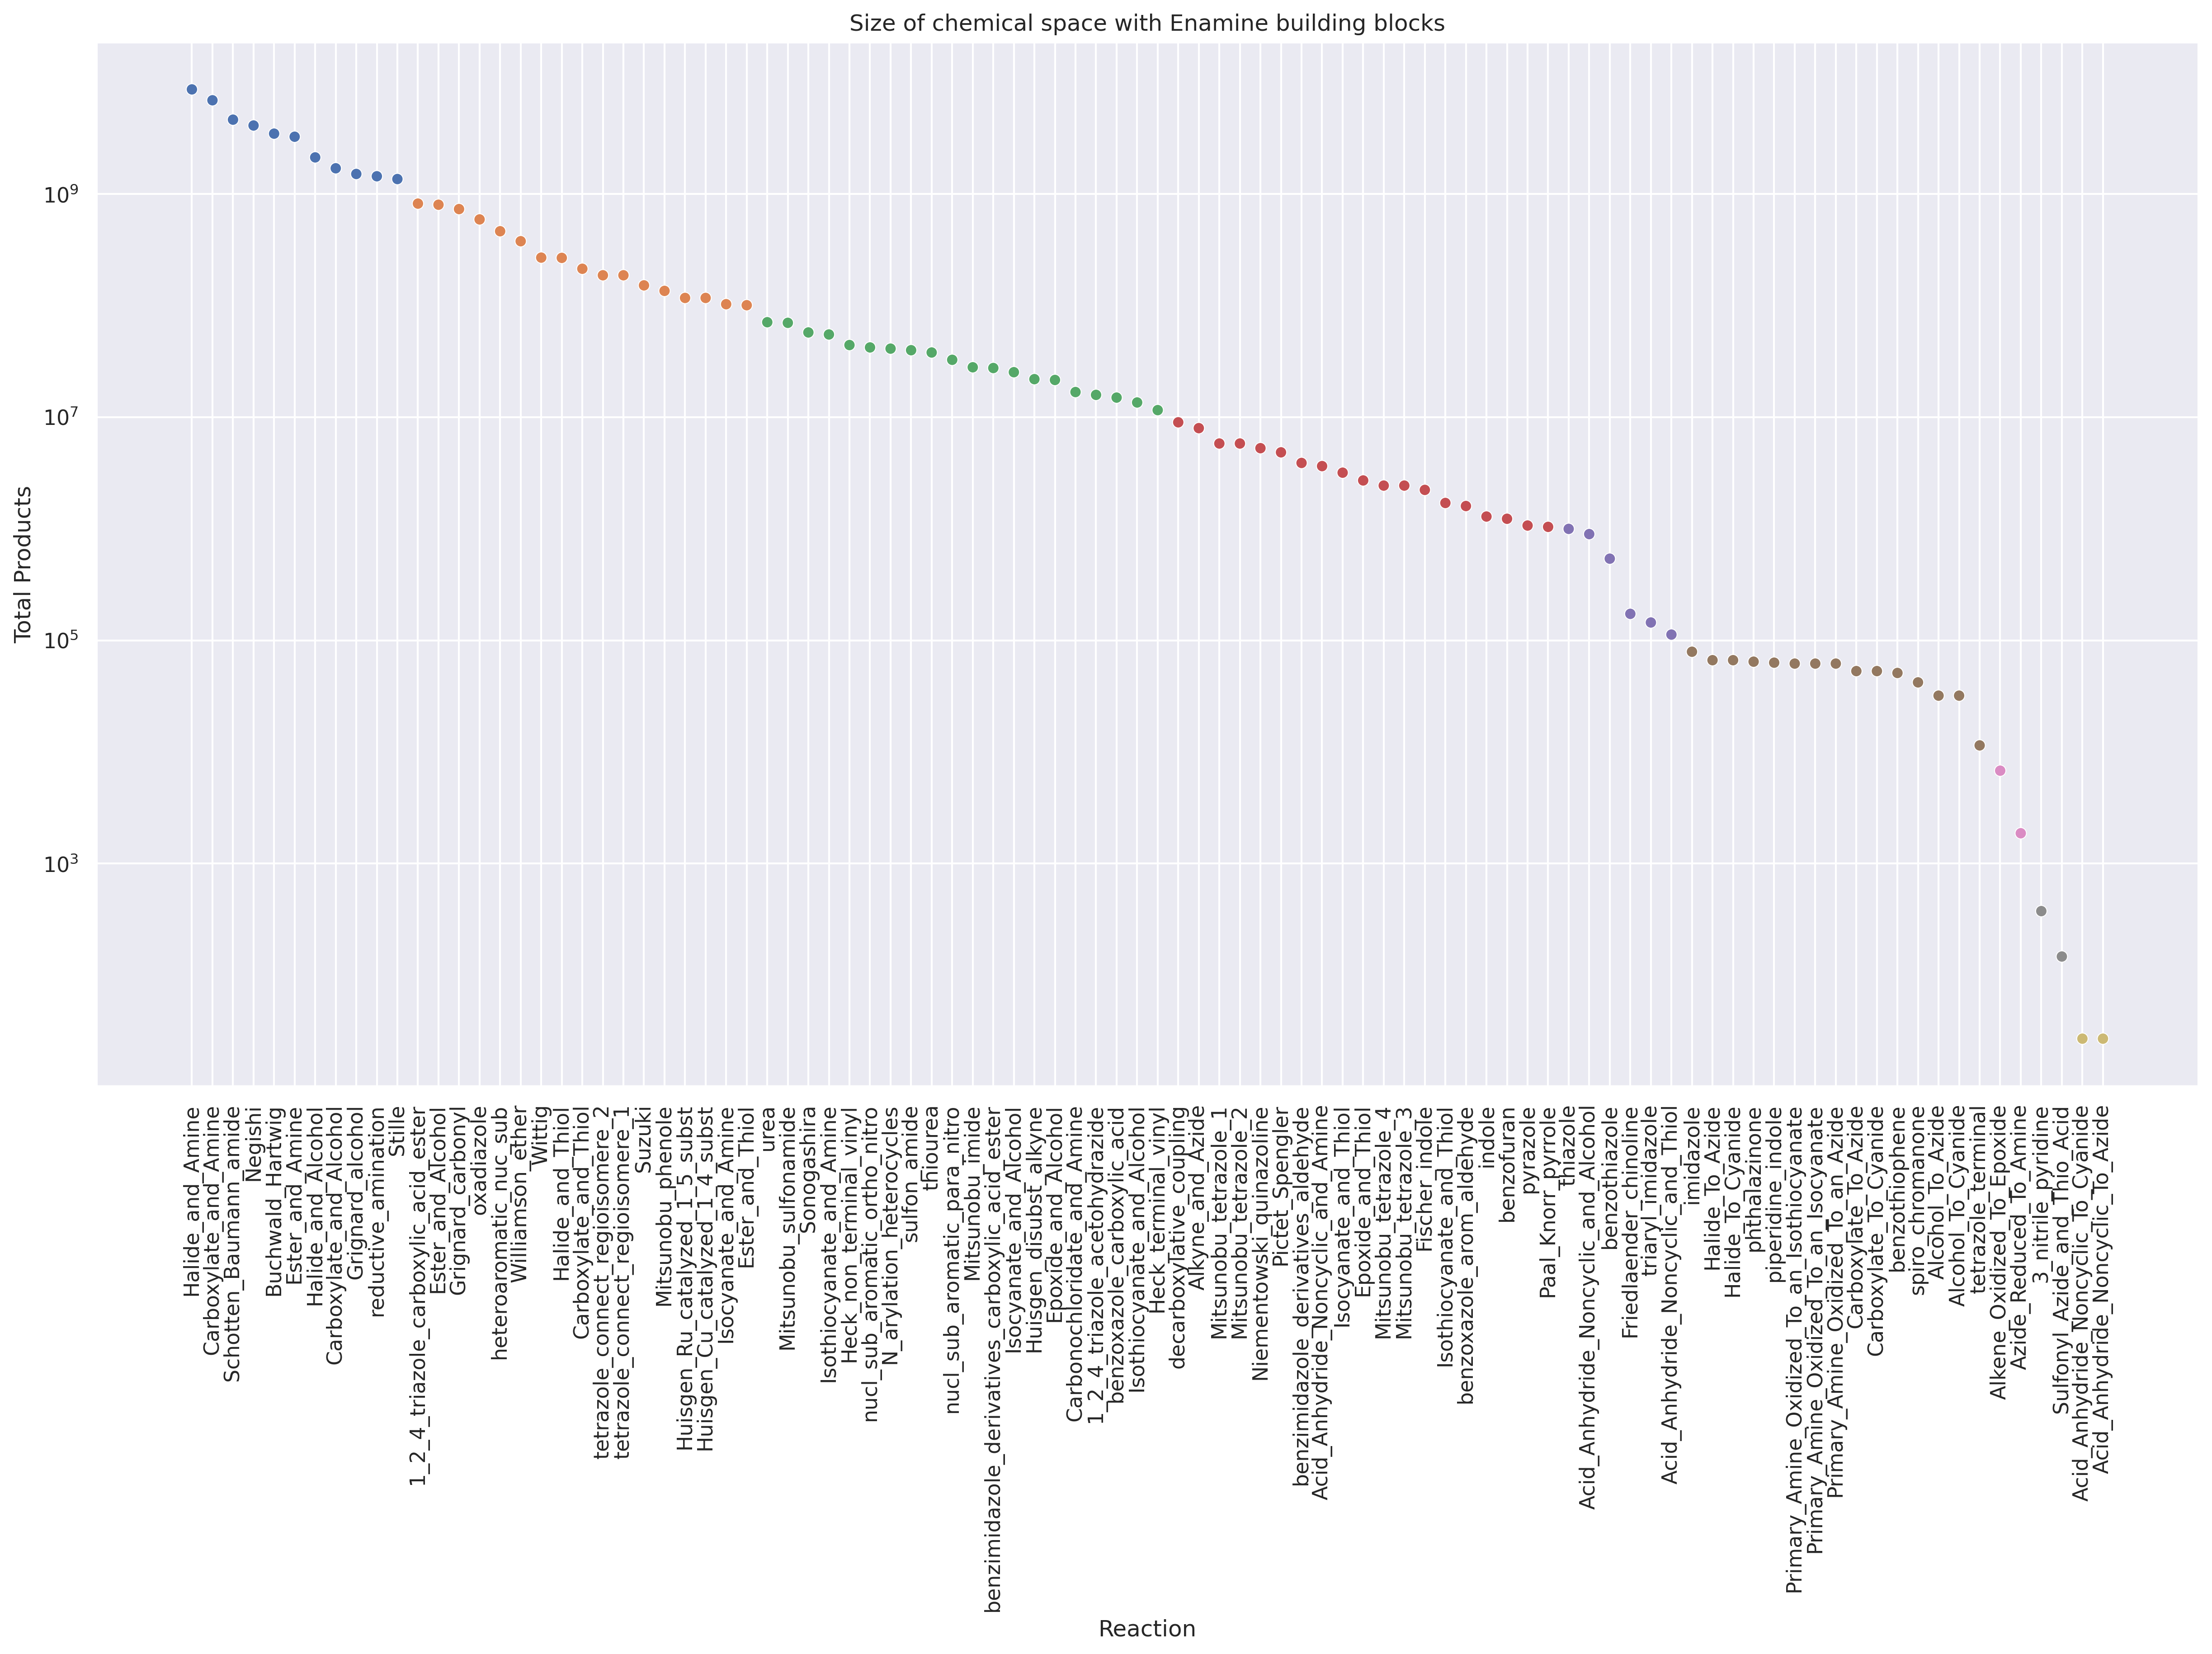

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(figsize=(20, 10))
g = sns.scatterplot(
    total_products.sort_values('Total Products', ascending=False),
    x='Reaction',
    y='Total Products',
    hue='Order of Magnitude',
    palette='deep',
    legend=False
)

g.figure.set_dpi(300)
g.semilogy()
plt.xticks(rotation=90)
plt.ylim(0)

plt.title('Size of chemical space with Enamine building blocks')

**Estimating multi-step cardinality.**

    - For each reaction, we find the fraction of building blocks that are compatible. We use that as a surrogate for the number of products from 1-step reactions that would be compatible with this reactant template.

    - We then multiply that by the cardinality of the other reactant class.
    
    - Repeat with the other reactant.
    
    - Sum.

In [149]:
import itertools

num_building_blocks = len(building_blocks)
total_one_step = total_products['Total Products'].sum()
total_by_step = [total_one_step, 0, 0]

for steps, total in enumerate(total_by_step):
    if steps < len(total_by_step) - 1:
        for reaction, counts_ in counts.items():

            # For each possible permutation of reactants
            reaction_total = 0
            for permutation in itertools.permutations(counts_):

                # Get fraction compatible to weight total from last step
                fraction_compatible = permutation[0] / num_building_blocks
                if len(permutation) > 1:
                    reaction_total += int(fraction_compatible * total) * permutation[1]
                else:
                    reaction_total += int(fraction_compatible * total)

            total_by_step[steps + 1] += reaction_total

Size of chemical space for each reaction.

In [160]:
for step, total in enumerate(total_by_step):
    print('Step', step, end=':\t')
    print('Size of Chemical Space', '%.2E' % int(total))

Step 0:	Size of Chemical Space 4.54E+10
Step 1:	Size of Chemical Space 1.57E+16
Step 2:	Size of Chemical Space 5.45E+21
